# Getting started with DeepMatcher

Note: you can run **[this notebook live in Google Colab](https://colab.research.google.com/github/softlab-unimore/Landmark/blob/master/quick_start_magellan.ipynb)** and use free GPUs provided by Google.

This tutorial describes how to effortlessly explaining entity matching. Specifically, we will see how to match pairs of tuples (also called data records or table rows) to determine if they refer to the same real world entity. To do so, we will need labeled examples as input, i.e., tuple pairs which have been annotated as matches or non-matches. This will be used to train a model to explain using supervised learning. After that you will apply Landmark to get an explanation of the model over a record from your data. 

In this notebook you will use the Magellan library to:

1.   Extract feature similarity between the entities of each pair.
2.   Apply a ML model over the extracted features to predict the label.



## Step 0. Setup

If you are running this notebook inside Colab, you will first need to install necessary packages by running the code below:

In [1]:
!pip install py_entitymatching

You may need to restart the kernel to use Magellan. That's OK.


In [2]:
!git clone git@github.com:softlab-unimore/Landmark.git

Cloning into 'Landmark'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [3]:
!git clone https://github.com/softlab-unimore/landmark.git
!pip install -r landmark/requirements.txt

fatal: destination path 'landmark' already exists and is not an empty directory.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import py_entitymatching as em # magellan

In [5]:

dataset_path = '/content/landmark/data/Abt-Buy/'
DA = em.read_csv_metadata(dataset_path + 'tableA.csv', key='id')[['id','name']]
DB = em.read_csv_metadata(dataset_path + 'tableB.csv', key='id')

simplified_columns = ['id','left_id','right_id','label','left_name','right_name']
train = pd.read_csv(dataset_path + 'train_merged.csv')[simplified_columns]
test = pd.read_csv(dataset_path + 'test_merged.csv')[simplified_columns]
valid = pd.read_csv(dataset_path + 'valid_merged.csv')[simplified_columns]

exclude_attrs=['id','left_id','right_id', 'label']

Metadata file is not present in the given path; proceeding to read the csv file.
Metadata file is not present in the given path; proceeding to read the csv file.


In [6]:
train
em.set_key(train, 'id')
# si settano le key dei due dataset
em.set_key(DA, 'id')
em.set_key(DB, 'id')
# si settano le foreign key in train
em.set_ltable(train, DA)
em.set_rtable(train, DB)
em.set_fk_ltable(train, 'left_id')
em.set_fk_rtable(train, 'right_id')

True

# Feature extraction

In [7]:
feature_table = em.get_features_for_matching(DA[['name']],DB[['name']], validate_inferred_attr_types=False)
feature_table.head()

,feature_name,left_attribute,right_attribute,left_attr_tokenizer,right_attr_tokenizer,simfunction,function,function_source,is_auto_generated
0,name_name_jac_qgm_3_qgm_3,name,name,qgm_3,qgm_3,jaccard,<function name_name_jac_qgm_3_qgm_3 at 0x7f12ee6c5830>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
1,name_name_cos_dlm_dc0_dlm_dc0,name,name,dlm_dc0,dlm_dc0,cosine,<function name_name_cos_dlm_dc0_dlm_dc0 at 0x7f12ee6c54d0>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
2,name_name_mel,name,name,None,None,monge_elkan,<function name_name_mel at 0x7f12ee6c5320>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
3,name_name_lev_dist,name,name,None,None,lev_dist,<function name_name_lev_dist at 0x7f12ee739830>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
4,name_name_lev_sim,name,name,None,None,lev_sim,<function name_name_lev_sim at 0x7f12ee7394d0>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True


# Model Training

In [8]:
H = em.extract_feature_vecs(train, feature_table=feature_table, )
H = H.fillna(H.mean())

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


In [9]:
H.head()


,id,left_id,right_id,name_name_jac_qgm_3_qgm_3,name_name_cos_dlm_dc0_dlm_dc0,name_name_mel,name_name_lev_dist,name_name_lev_sim
0,0,730,775,0.280488,0.404520,0.733421,41.0,0.405797
1,1,731,775,0.296296,0.404520,0.750564,39.0,0.434783
2,2,735,775,0.558824,0.674200,0.806667,30.0,0.571429
3,3,732,775,0.472222,0.539360,0.789124,32.0,0.542857
4,4,734,775,0.419753,0.516398,0.778857,42.0,0.475000


In [10]:
X = H.iloc[:, 3:]
y = train['label']
model = em.LogRegMatcher(name='LR', random_state=0, n_jobs=-1,
                         C=0.5, max_iter=100, class_weight={0: 1, 1:3})


test_precision    0.457200
test_recall       0.459360
test_f1           0.457231
dtype: float64

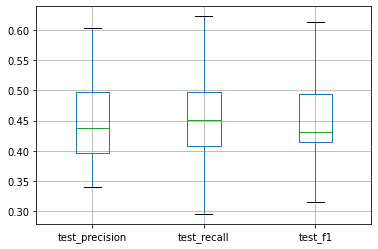

In [11]:
from sklearn.model_selection import cross_validate

scores = pd.DataFrame(cross_validate(model.clf, X, y, cv=10, scoring=('precision', 'recall', 'f1')))
scores = scores.iloc[:,-3:] # remove time measures
scores.boxplot()
scores.mean()

In [12]:
model.fit(X,y)

# Explanation routine

In [13]:
from landmark.landmark.landmark import Landmark
from landmark.wrapper.Magellan_wrapper import Magellan_wrapper

In [14]:
mg_wrapped = Magellan_wrapper(model, feature_table, exclude_attrs)
explainer = Landmark(mg_wrapped.predict, test, exclude_attrs=exclude_attrs, lprefix='left_', rprefix='right_', split_expression=r' ')

In [15]:
preds = mg_wrapped.predict(test)
test['pred'] = preds

In [29]:
el = test[test.id==270]
display(el)

,id,left_id,right_id,label,left_name,right_name,pred
270,270,574,399,0,sony digital slr camera with lens kit dslra200w,nikon digital camera leather case 5811,0.036606


In [30]:
%%time
exp = explainer.explain(el)

CPU times: user 1.79 s, sys: 126 ms, total: 1.92 s
Wall time: 1.78 s


In [31]:
exp

,index,id,column,position,word,word_prefix,impact,conf
0,0,270,right_name,11,dslra200w,A11_dslra200w,0.243544,left_land_injected
1,1,270,right_name,1,digital,A01_digital,0.156621,left_land_injected
2,2,270,right_name,2,camera,A02_camera,0.145481,left_land_injected
3,3,270,right_name,8,with,A08_with,0.134797,left_land_injected
4,4,270,right_name,9,lens,A09_lens,0.129607,left_land_injected
5,5,270,right_name,10,kit,A10_kit,0.113321,left_land_injected
6,6,270,right_name,7,slr,A07_slr,0.086123,left_land_injected
7,7,270,right_name,6,sony,A06_sony,0.082174,left_land_injected
8,8,270,right_name,5,5811,A05_5811,-0.060175,left_land_injected
9,9,270,right_name,0,nikon,A00_nikon,-0.054199,left_land_injected


,id,left_id,right_id,label,left_name,right_name,pred
270,270,574,399,0,sony digital slr camera with lens kit dslra200w,nikon digital camera leather case 5811,0.036606


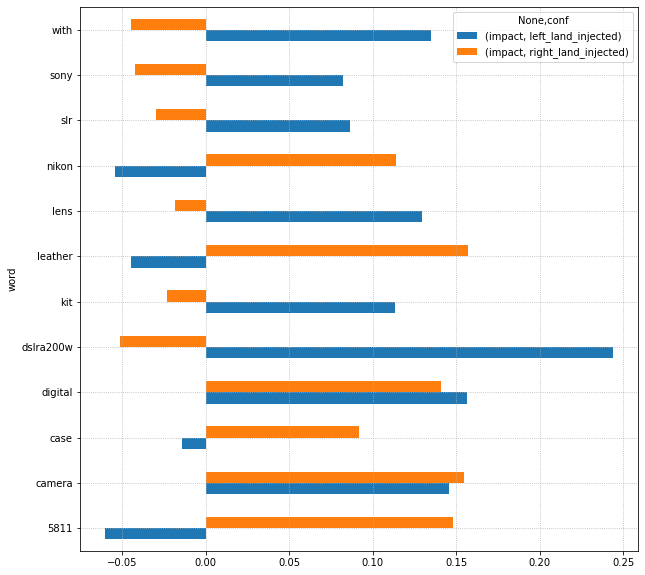

In [37]:
to_plot = exp
figsize = (10,10)
aggregated = to_plot.pivot_table(index='word',values=['impact'],columns=['conf'], aggfunc='max' )
plot = aggregated.plot(kind='barh', figsize=figsize,)
plt.gca().grid(True, linestyle=':', axis='both')
el